### 1. Load Data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
import category_encoders as ce
import matplotlib.pyplot as plt
import xgboost as xgb
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, average_precision_score, confusion_matrix

import pickle
import joblib
import json
import shap 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.5f}'.format

df = pd.read_csv("./dataset.csv", sep = ";")
df['has_paid'] = df['has_paid'].astype(int)

df_nna = df[df['default'].notna()]  # observations for which we have default values (Training + Validation set)

df_na = df[df['default'].isna()]    # observations for which we dont have default values (Unlabeled data)

### 2. Perform EDA

<p> <b>A.</b> Checking for correlation between the variables. There seems to be no "near-perfect" correlation, but there is significant correlation between some pairs of variables. This could be an issue for a model where high multicolinearity might yield biased model parameters such as Logistic regression. However, I decided to use a non-parametric model - XGBoost and will therefore keep all variables in the model.

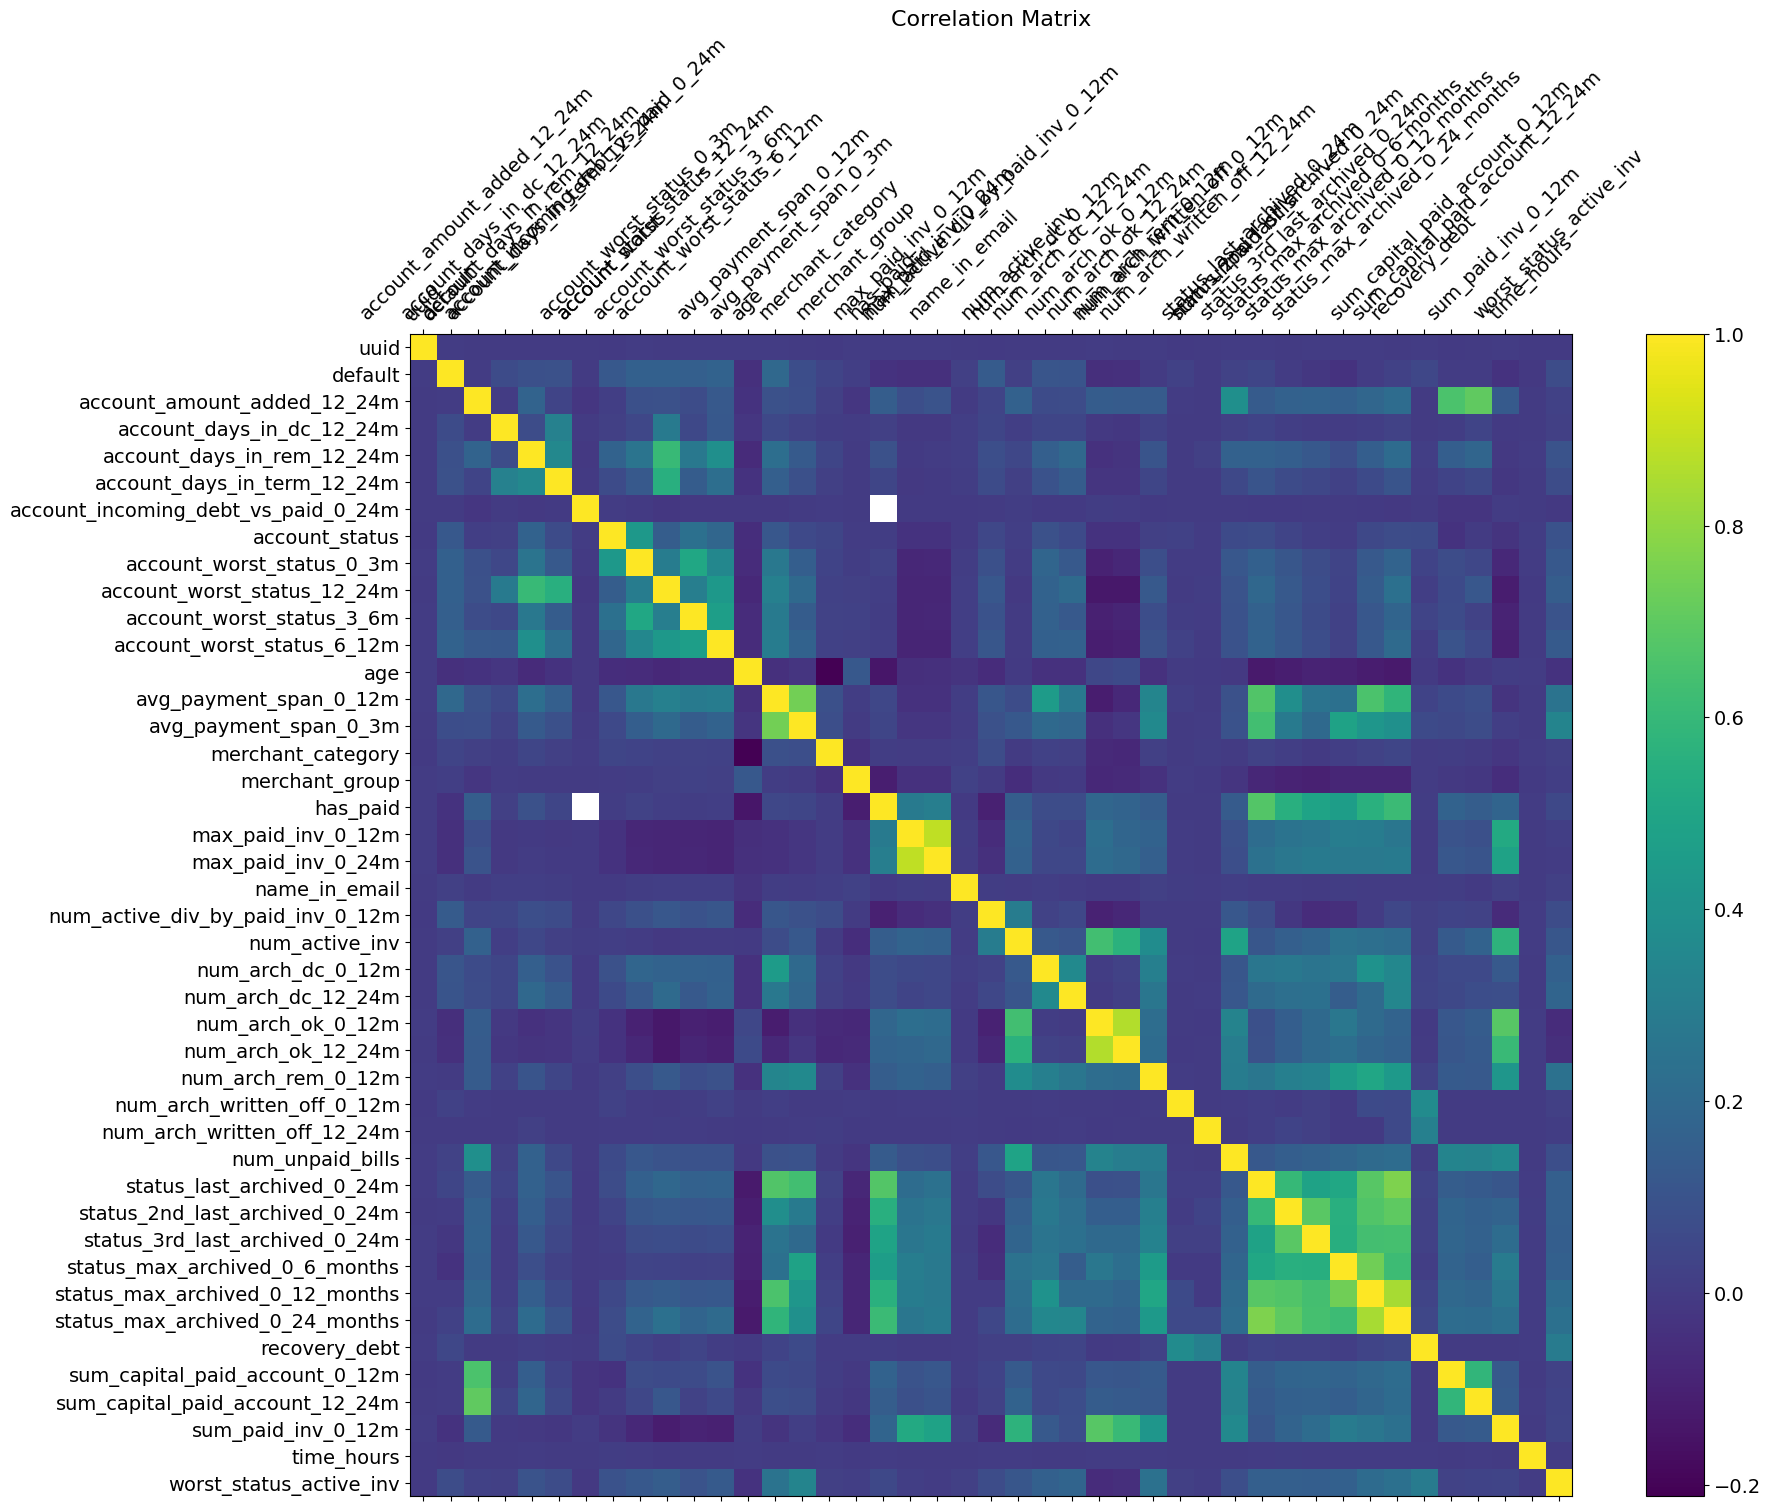

In [2]:
#Plotting the correlation matrix

df.dtypes
df['uuid']=df['uuid'].astype('category').cat.codes
df['merchant_category']=df['merchant_category'].astype('category').cat.codes
df['merchant_group']=df['merchant_group'].astype('category').cat.codes
df['name_in_email']=df['name_in_email'].astype('category').cat.codes

f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

<p> <b> B. </b> For each of the 15 variables with NAs, there seems to be significant difference in the Default Rate between the observations with NAs compared to observations without NAs. It seems that observations with NAs hold important information. Therefore, I decided to apply Weight of Evidence encoding, which is useful because it encodes all values in the dataset as well as NA values. That way I will use all available information and will not have to discard any observations, nore would I have to approximate NAs with some other statistic (e.g. with medians)

In [3]:
## Testing if the observations with NAs have different Default Rates than the observations without NAs.

nna_perc = list(df_nna.apply(lambda x: np.mean(df_nna['default'][x.notna()])))
nna_def = list(df_nna.apply(lambda x: int(np.sum(df_nna['default'][x.notna()]))))
nna_all = list(df_nna.apply(lambda x: len(df_nna['default'][x.notna()])))

na_perc  = list(df_nna.apply(lambda x: np.mean(df_nna['default'][x.isna()])))
na_def  = list(df_nna.apply(lambda x: int(np.sum(df_nna['default'][x.isna()]))))
na_all  = list(df_nna.apply(lambda x: len(df_nna['default'][x.isna()])))
cols = list(df_nna.columns)

na_nna_compare = pd.DataFrame({'VarName': cols,
                               '% Default Not NAs': nna_perc,
                               'Count Default Not NAs': nna_def,
                               'Count All Not NAs': nna_all,
                               '% Default NAs': na_perc,
                               'Count Default NAs': na_def,
                               'Count All NAs': na_all})

na_nna_compare.dropna(inplace=True)


def p_value(a,b,c,d):
    count = [a, b]      
    nobs = [c, d]          
    stat, pval = proportions_ztest(count, nobs)
    #pval=str(a/c) +''+str(b/d)
    return pval

na_nna_compare['proportions test_p value'] = na_nna_compare.apply(lambda x: p_value(x['Count Default Not NAs'], x['Count Default NAs'], x['Count All Not NAs'], x['Count All NAs'] ), axis=1)
na_nna_compare

,VarName,% Default Not NAs,Count Default Not NAs,Count All Not NAs,% Default NAs,Count Default NAs,Count All NAs,proportions test_p value
3,account_days_in_dc_12_24m,0.01510,1197,79293,0.00852,91,10683,0.00000
4,account_days_in_rem_12_24m,0.01510,1197,79293,0.00852,91,10683,0.00000
5,account_days_in_term_12_24m,0.01510,1197,79293,0.00852,91,10683,0.00000
6,account_incoming_debt_vs_paid_0_24m,0.01950,714,36619,0.01076,574,53357,0.00000
7,account_status,0.02037,836,41042,0.00924,452,48934,0.00000
8,account_worst_status_0_3m,0.02037,836,41042,0.00924,452,48934,0.00000
9,account_worst_status_12_24m,0.01805,540,29921,0.01246,748,60055,0.00000
10,account_worst_status_3_6m,0.01888,718,38038,0.01097,570,51938,0.00000
11,account_worst_status_6_12m,0.01839,656,35663,0.01164,632,54313,0.00000
13,avg_payment_span_0_12m,0.00978,670,68508,0.02879,618,21468,0.00000


<p> <b>C.</b> When comparing the distributions of predictor variables between observations which defaulted against the ones which did not default, we observe obvious differences between distributions </p>

account_amount_added_12_24m


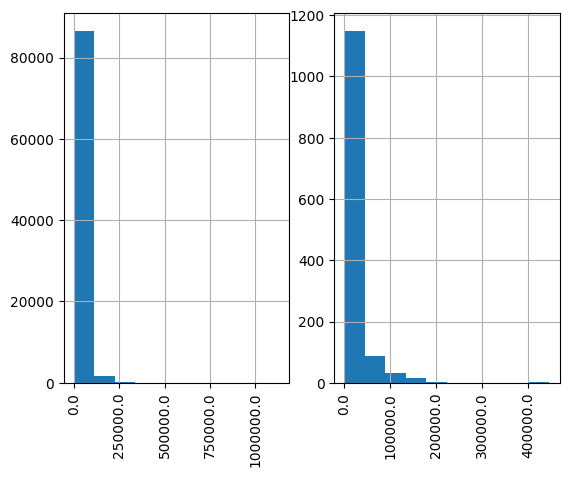

account_days_in_dc_12_24m


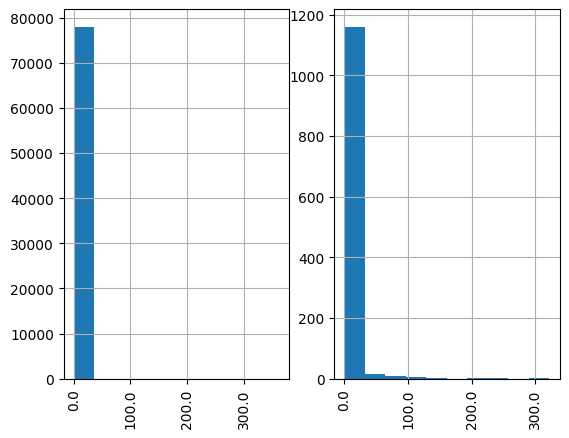

account_days_in_rem_12_24m


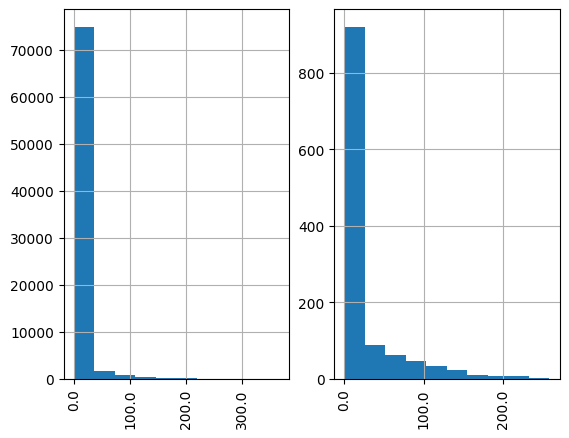

account_days_in_term_12_24m


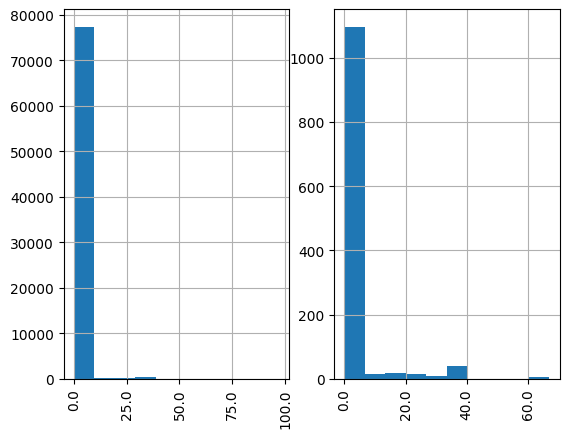

account_incoming_debt_vs_paid_0_24m


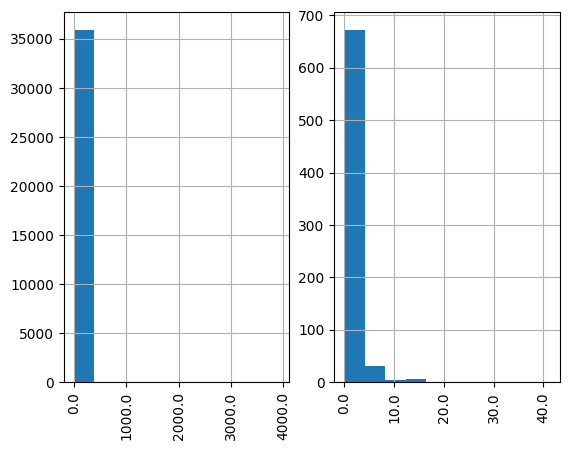

account_status


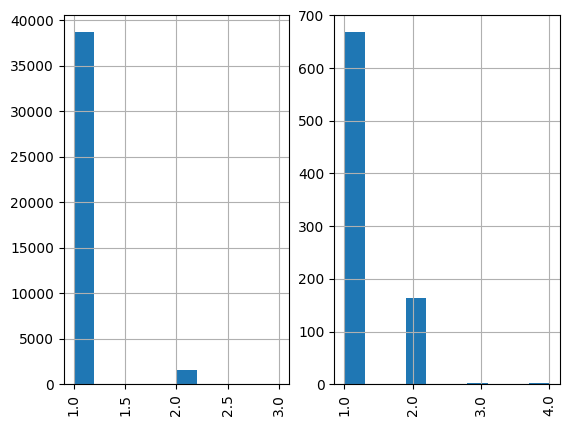

account_worst_status_0_3m


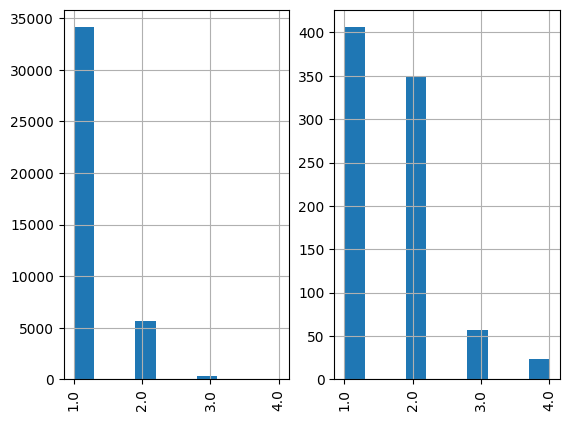

account_worst_status_12_24m


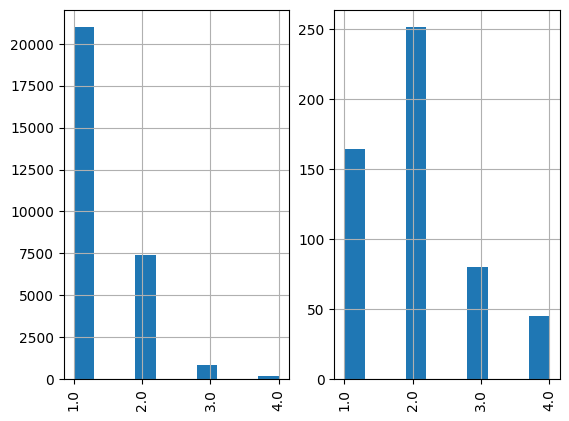

account_worst_status_3_6m


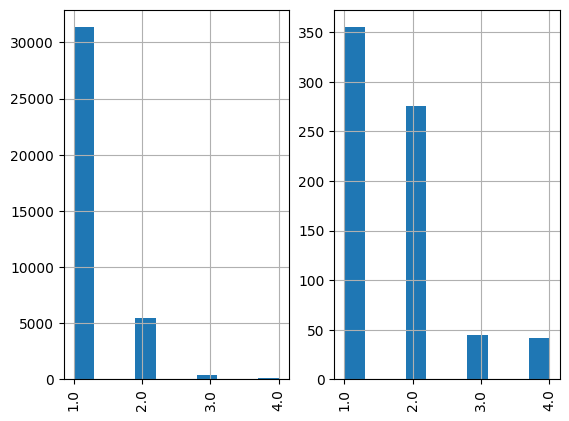

account_worst_status_6_12m


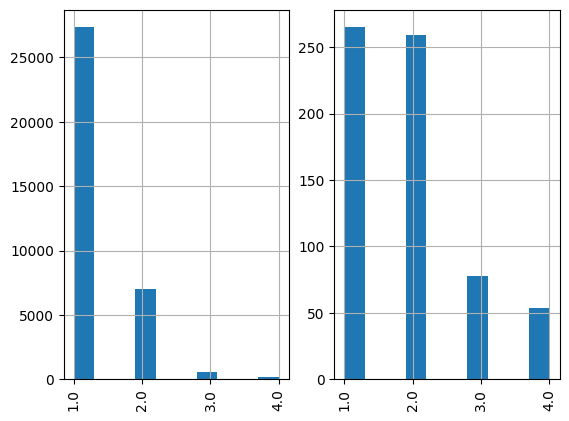

age


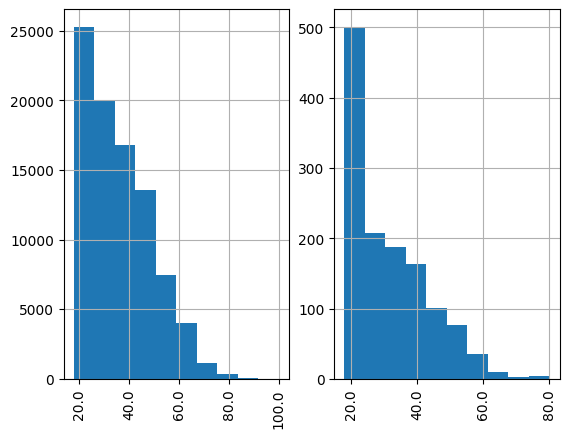

avg_payment_span_0_12m


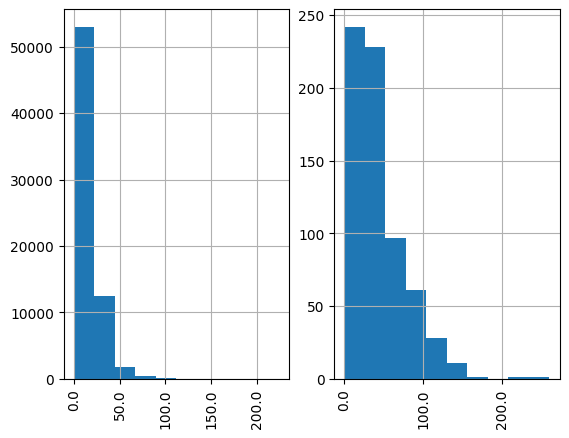

avg_payment_span_0_3m


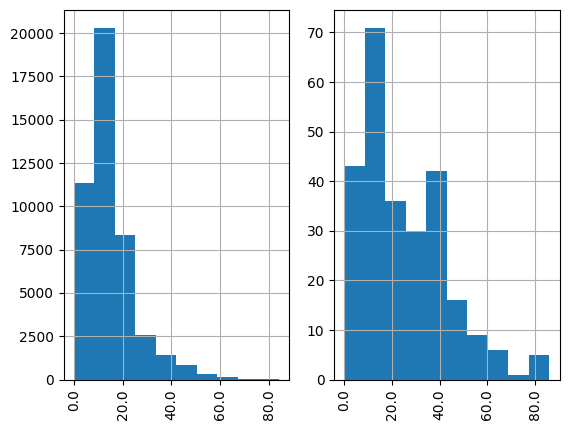

merchant_category


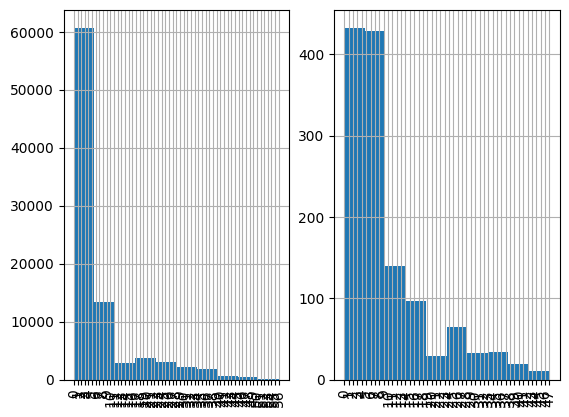

merchant_group


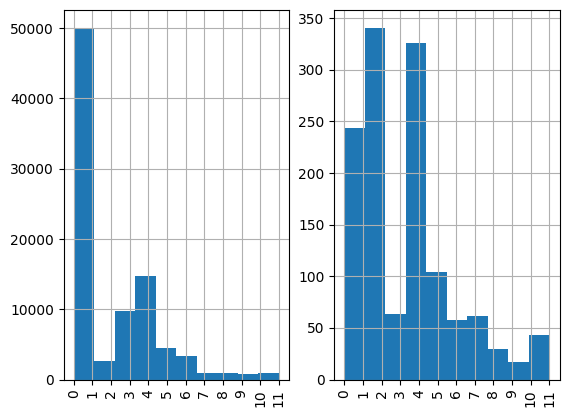

has_paid


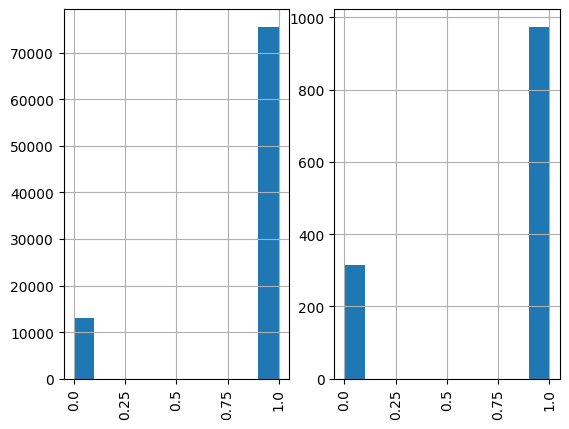

max_paid_inv_0_12m


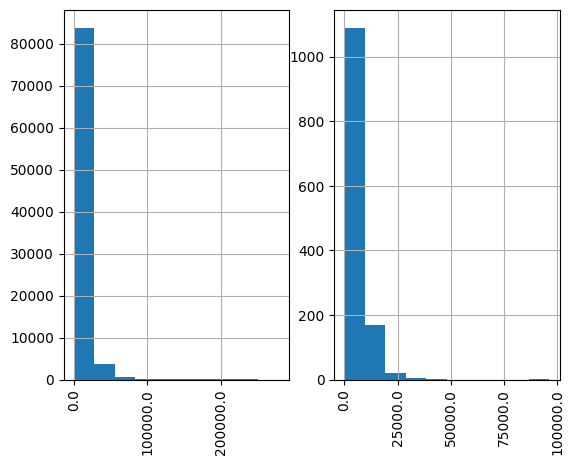

max_paid_inv_0_24m


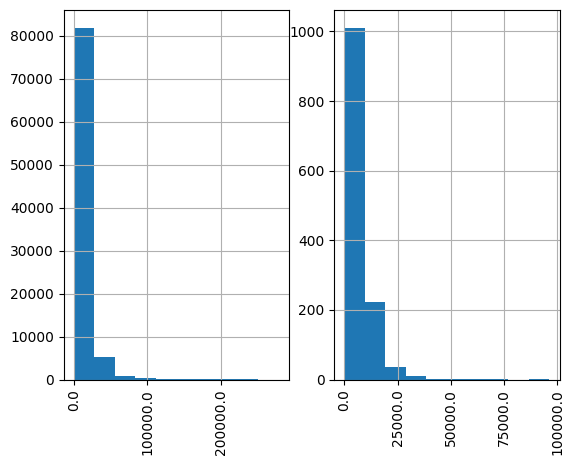

name_in_email


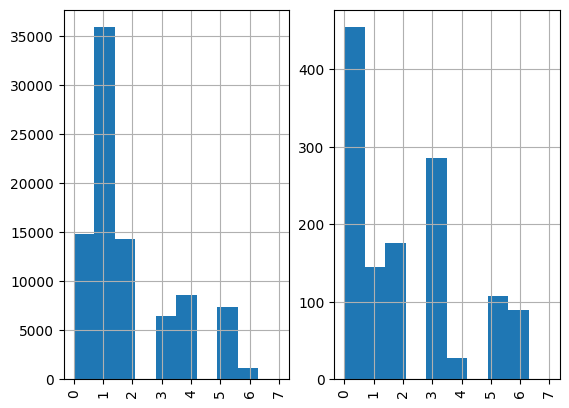

num_active_div_by_paid_inv_0_12m


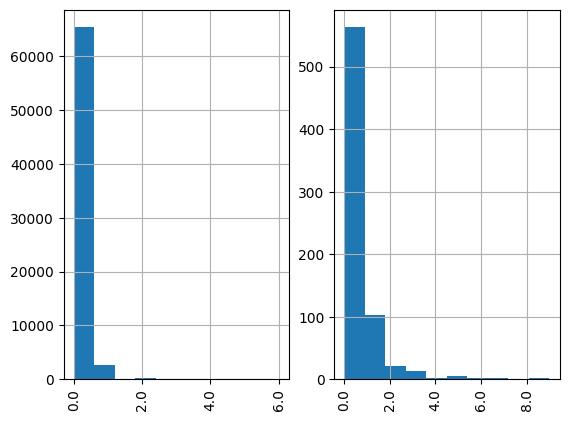

num_active_inv


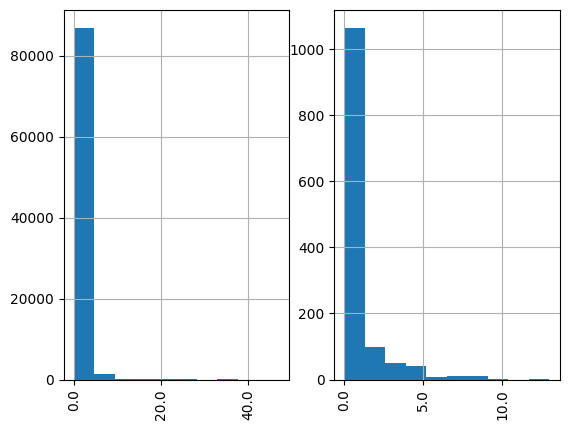

num_arch_dc_0_12m


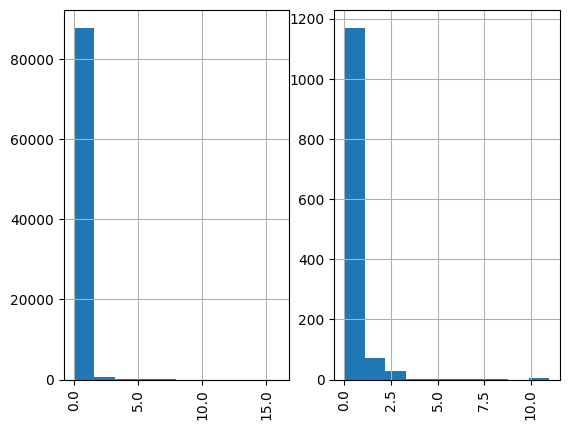

num_arch_dc_12_24m


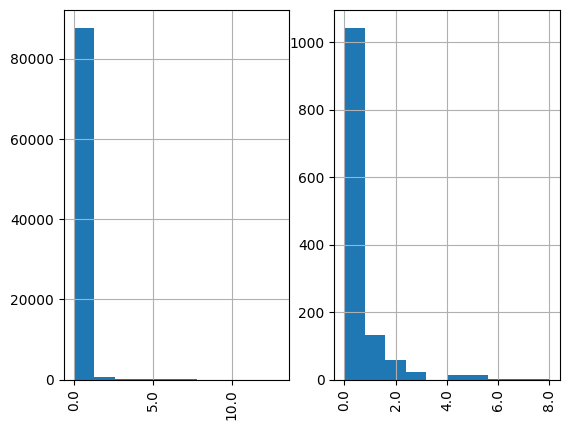

num_arch_ok_0_12m


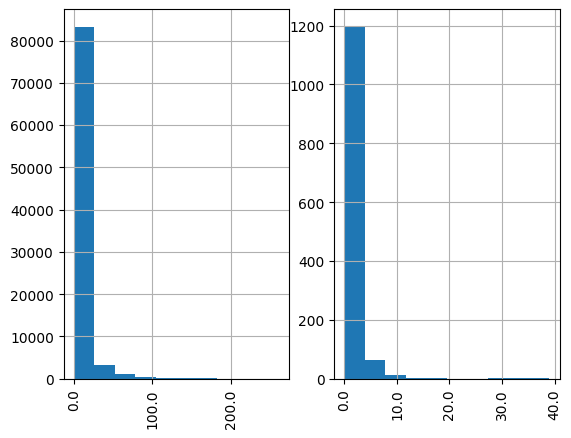

num_arch_ok_12_24m


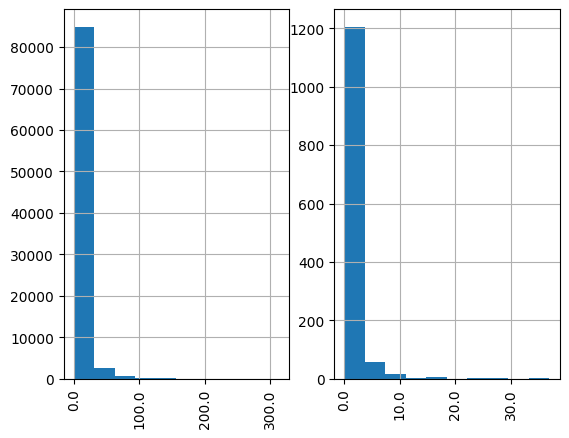

num_arch_rem_0_12m


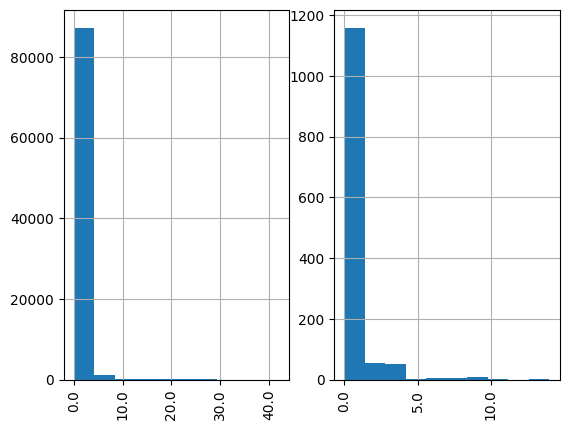

num_arch_written_off_0_12m


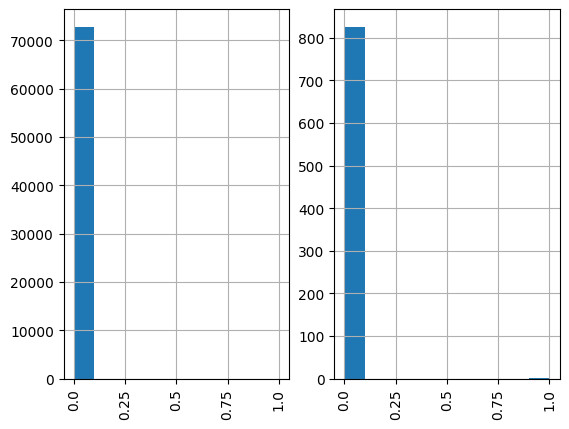

num_arch_written_off_12_24m


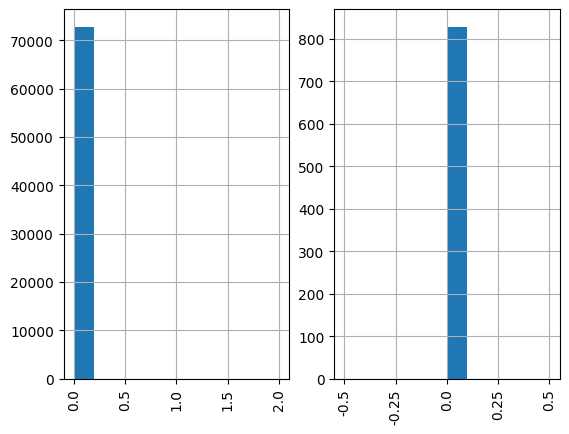

num_unpaid_bills


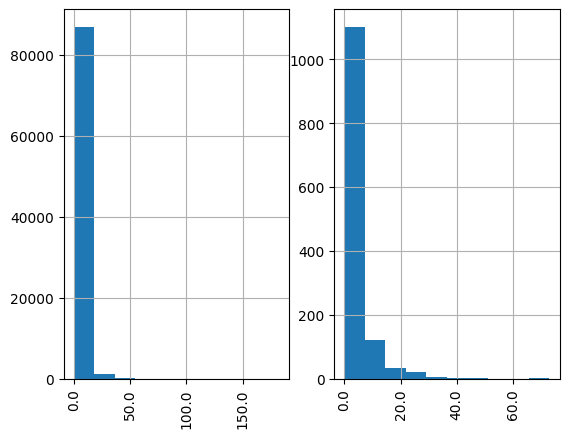

status_last_archived_0_24m


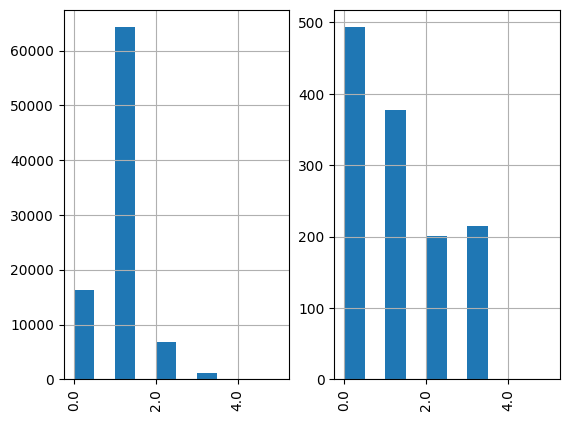

status_2nd_last_archived_0_24m


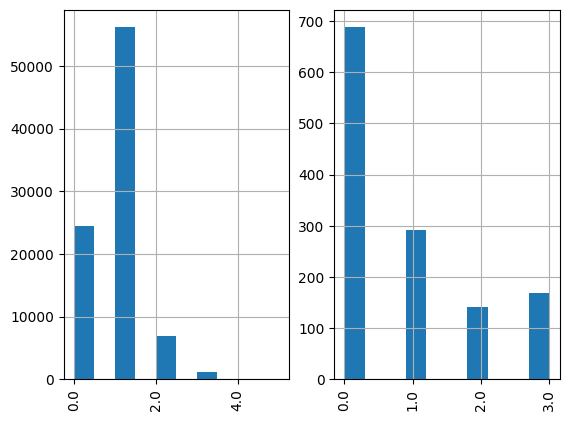

status_3rd_last_archived_0_24m


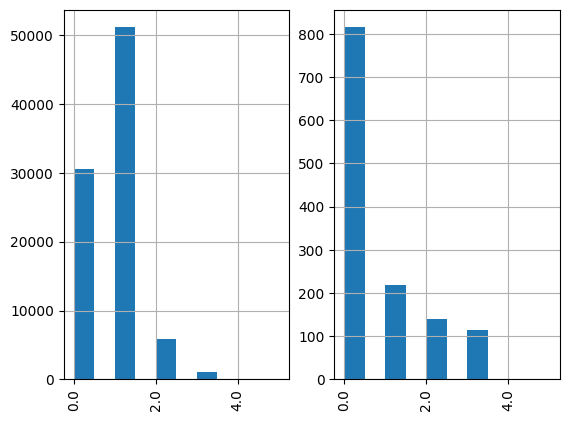

status_max_archived_0_6_months


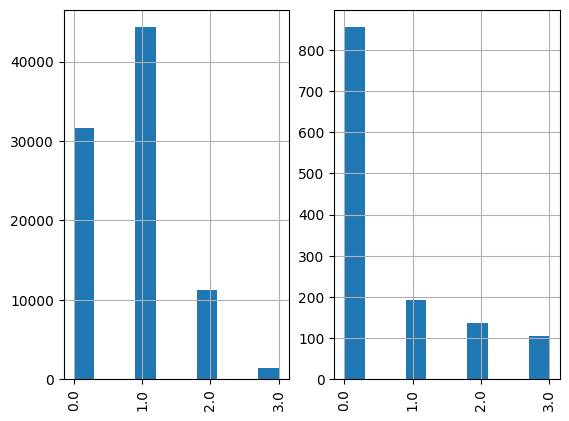

status_max_archived_0_12_months


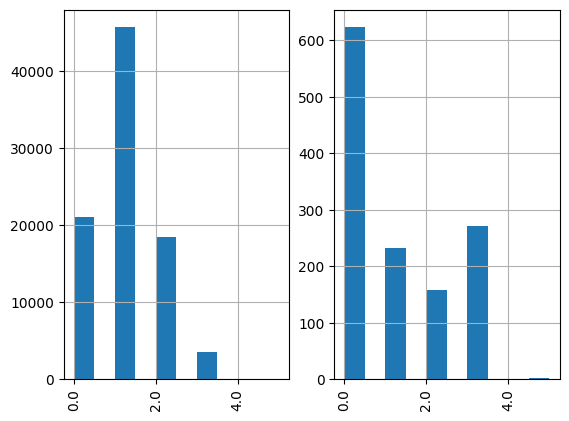

status_max_archived_0_24_months


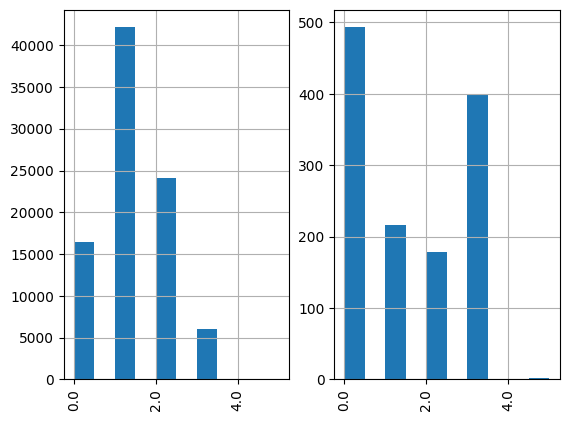

recovery_debt


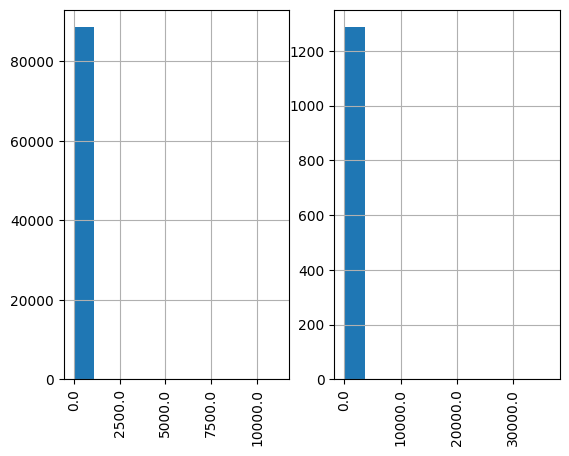

sum_capital_paid_account_0_12m


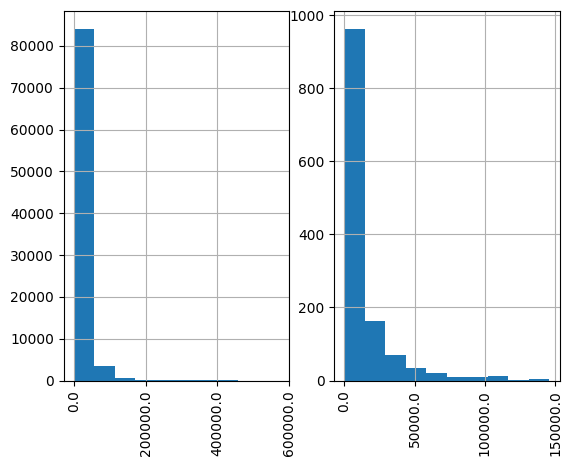

sum_capital_paid_account_12_24m


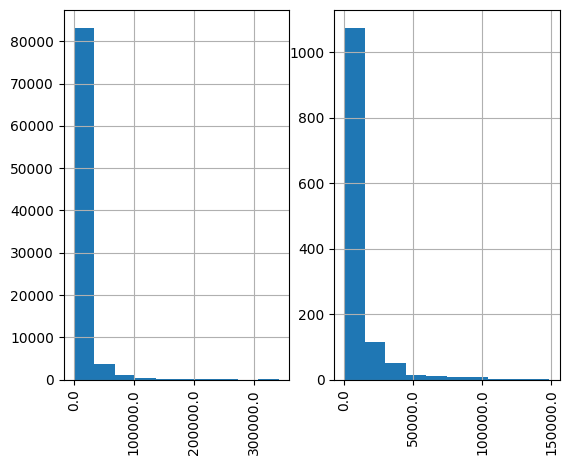

sum_paid_inv_0_12m


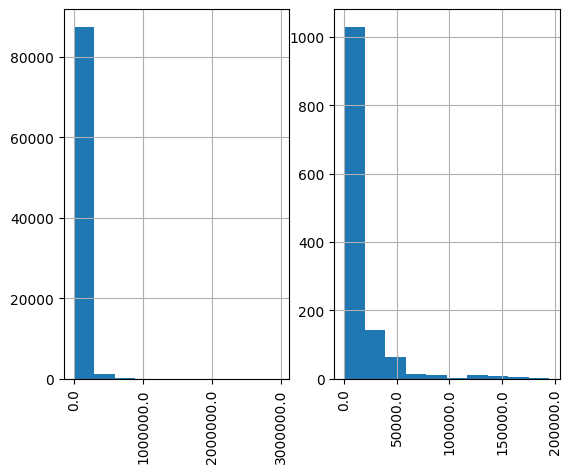

time_hours


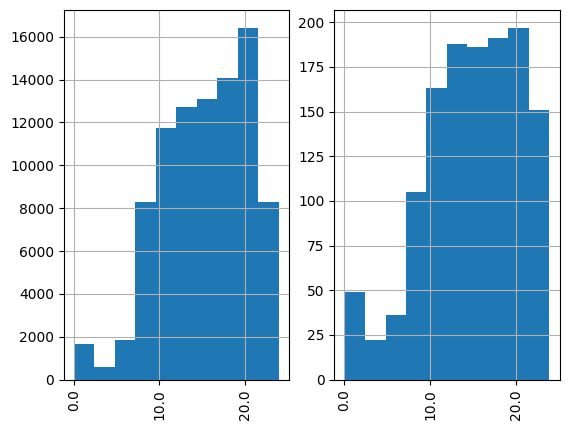

worst_status_active_inv


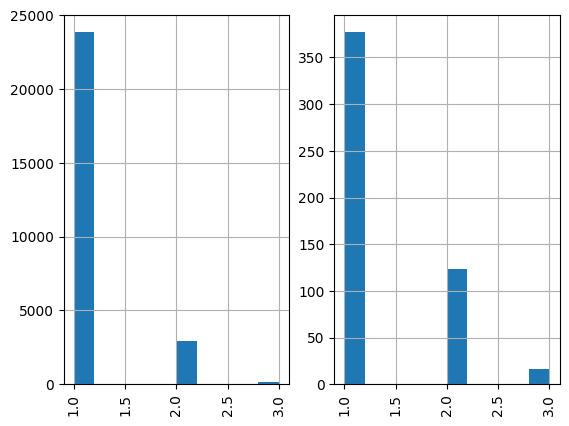

In [4]:
## Plotting the histograms for all variables. 
##We can see differences in distribution between observations with and without NA values(???)

df_nna['has_paid'] = df_nna['has_paid'].astype(int)
#plt.setp(axa.xaxis.get_majorticklabels(), rotation=45)

for i in df_nna.columns[2:]:
    print(str(i))
    fig, axes = plt.subplots(1, 2)
    df_nna.loc[(df_nna["default"] ==0)][i].hist( bins=10, ax=axes[0])
    df_nna.loc[(df_nna["default"] ==1)][i].hist( bins=10, ax=axes[1])
    
    
    for ax in axes:
        ax.set_xticklabels(ax.get_xticks(), rotation=90)
    plt.show()


### 3. Data Preparation

<p> <b>A.</b>  
WOE encoding can be applied on either categorical or binned numerical variables. I have therefore identified all numerical variables in the dataset and have binned them into 20 bins each, before applying WOE encoding. Large number of bins used ensures that not much information had been lost in this transformation. Binning the numerical variables is also standard practice in credit risk  </p>

In [5]:
# idetifying numerical and categorical variables in the dataset

def num_cat(df):
    df_num_cat = pd.DataFrame(columns=['Columns', 'Unique Val','Unique Val Count'])
    for col in df.columns:
        row = pd.DataFrame({'Columns': [col], 'Unique Val': [df_nna[col].unique(),], 'Unique Val Count': [len(df_nna[col].unique())]})
        df_num_cat = pd.concat([df_num_cat,row])
        
    df_num_cat['Variable Type'] = np.where((df_num_cat['Unique Val Count'] <15) , 'Categorical', 'Numerical')
    df_num_cat['Variable Type'] = np.where(df_num_cat['Columns'].isin(['merchant_category','merchant_group', 'name_in_email']), 'Categorical', df_num_cat['Variable Type'])
    df_num_cat['Has NA'] = np.where(df_num_cat['Columns'].isin(list(na_nna_compare['VarName'])), 'NA', 'OK')

    df_num_cat['Variable Type'] = np.where(df_num_cat['Columns'].isin(['uuid','default']), '/', df_num_cat['Variable Type'])
    return df_num_cat

df_num_cat = num_cat(df_nna) 
df_num_cat

,Columns,Unique Val,Unique Val Count,Variable Type,Has NA
0,uuid,"[63f69b2c-8b1c-4740-b78d-52ed9a4515ac, 0e96118...",89976,/,OK
0,default,"[0.0, 1.0]",2,/,OK
0,account_amount_added_12_24m,"[0, 57229, 148922, 11205, 3529, 15122, 103632,...",21733,Numerical,OK
0,account_days_in_dc_12_24m,"[0.0, nan, 9.0, 63.0, 131.0, 56.0, 19.0, 291.0...",120,Numerical,NA
0,account_days_in_rem_12_24m,"[0.0, nan, 142.0, 47.0, 26.0, 24.0, 21.0, 29.0...",279,Numerical,NA
0,account_days_in_term_12_24m,"[0.0, nan, 29.0, 16.0, 22.0, 23.0, 34.0, 50.0,...",62,Numerical,NA
0,account_incoming_debt_vs_paid_0_24m,"[0.0, nan, 0.232244230969046, 0.96905508904678...",21557,Numerical,NA
0,account_status,"[1.0, nan, 2.0, 3.0, 4.0]",5,Categorical,NA
0,account_worst_status_0_3m,"[1.0, nan, 2.0, 3.0, 4.0]",5,Categorical,NA
0,account_worst_status_12_24m,"[nan, 1.0, 2.0, 3.0, 4.0]",5,Categorical,NA


<p> <b>B.</b> Here I define the TrainValTest and WoeEncode classes. The TrainValTest class splits the dataset into Train, Validation and Test subsets, and WoeEncode class encodes all the subsets using Weight-of-Evidence encoding.  </p>

In [6]:
import pandas as pd
import numpy as np
import warnings
import random
import category_encoders as ce
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score, precision_score, average_precision_score, confusion_matrix


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
pd.options.display.float_format = '{:.5f}'.format


class TrainValTest:
    def __init__(self, path, val_prop, test_prop):
        """
        Initialize the TrainVal class by splitting data into train, validation, and test sets.

        Parameters:
        - path (str): Path to the CSV file.
        - val_prop (float): Proportion of data for the validation set.
        - test_prop (float): Proportion of data for the test set.
        """

        _df = pd.read_csv(path, sep=";")
        _df = _df[~_df['default'].isna()]  # .head(1000)

        _val_size = int(val_prop * len(_df))
        _test_size = int(test_prop * len(_df))

        _pop_index = list(_df.index)
        _val_index = random.sample(_pop_index, _val_size)

        _pop_index = list(set(_pop_index) - set(_val_index))
        _test_index = random.sample(_pop_index, _test_size)

        _train_index = list(set(_pop_index) - set(_test_index))

        _train = _df[_df.index.isin(_train_index)].reset_index(drop=True)
        _test = _df[_df.index.isin(_test_index)].reset_index(drop=True)
        _val = _df[_df.index.isin(_val_index)].reset_index(drop=True)

        _train_y = _train['default'].copy()

        _val_y = _val['default'].copy()
        _val['default'] = np.nan

        _test_y = _test['default'].copy()
        _test['default'] = np.nan

        self.train = _train
        self.train_y = _train_y

        self.val = _val
        self.val_y = _val_y

        self.test = _test
        self.test_y = _test_y


class WoeEncode:
    def __init__(self, df):

        """
        The WoeEncode class receives a dataset to encode.
        The class should be initialized with a train set.
        The class creates an object which holds the encoded train set,
        as well as methods to encode the validation and test set.

        Parameters:
        - df (pd.DataFrame): the training dataset
        """

        self.df = df
        self.df['has_paid'] = self.df['has_paid'].astype(int)
        self.df_nna = self.df[self.df['default'].notna()]

        # self.df_na = self.df[self.df['default'].isna()]

        self.df_num_cat = self.num_cat()
        self.df_nna_bin, self.num_vars = self.num_bin()

        self.df_nna_bin_woe, self.woe_cols = self.WOE()
        self.lookup_table = self.lookup()
        # self.df_na_bin_woe = self.na_bin_WOE()

    def num_cat(self):
        """
        The num_cat method separates the dataset into categorical and numerical features.
        This is done because the numerical features must be binned before encoding.
        The method returns a summary table which classifies the features into either numerical or categorical

        Parameters:
        -none
        """
        nan_col_list = self.df_nna.columns[self.df_nna.isnull().any()]
        columns = self.df_nna.columns
        unique_vals = [self.df_nna[col].unique() for col in columns]
        unique_counts = [len(vals) for vals in unique_vals]

        df_num_cat = pd.DataFrame({
            'Columns': columns,
            'Unique Val': unique_vals,
            'Unique Val Count': unique_counts
        })

        df_num_cat['Variable Type'] = np.where(df_num_cat['Unique Val Count'] < 15, 'Categorical', 'Numerical')
        df_num_cat.loc[df_num_cat['Columns'].isin(
            ['merchant_category', 'merchant_group', 'name_in_email']), 'Variable Type'] = 'Categorical'
        df_num_cat.loc[df_num_cat['Columns'].isin(['uuid', 'default']), 'Variable Type'] = '/'
        df_num_cat['Has NA'] = np.where(df_num_cat['Columns'].isin(nan_col_list), 'NA', 'OK')
        return df_num_cat

    def num_bin(self):
        """
        The method num_bin utilizes the df_num_cat object and returns a dataframe object,
        whose numerical features have been binned into 20 bins each.
        The method also returns a list of all numerical columns/features.

        Parameters:
        -none
        """
        df_nna_bin = self.df_nna.copy()
        num_vars = list(self.df_num_cat['Columns'].loc[self.df_num_cat['Variable Type'] == 'Numerical'])
        for i in num_vars:
            df_nna_bin[i] = pd.cut(df_nna_bin[i], bins=20, precision=0)
        df_nna_bin[self.df_nna.columns[2:]] = df_nna_bin[self.df_nna.columns[2:]].astype(str)
        return df_nna_bin, num_vars

    def WOE(self):
        """
        The WOE class, encodes the train dataset, whose numerical features have previously been binned

        Parameters:
        -none
        """
        data_set = self.df_nna_bin
        data_targets = data_set['default']
        data_features = data_set.drop(['default', 'uuid'], axis=1)
        columns = [col for col in data_features.columns]
        woe_encoder = ce.WOEEncoder(cols=columns)
        woe_encoded_data = woe_encoder.fit_transform(data_features[columns], data_targets).add_suffix('_woe')
        return data_set.join(woe_encoded_data), list(woe_encoded_data.columns)

    def lookup(self):

        """
        The lookup method serves to define a lookup table which is a part of the mapping table,
        later used to WOE encode the validation and train dataset.

        Parameters:
        -none
        """
        col_name, lower_bound, upper_bound, orig_value = [], [], [], []
        for i in self.num_vars:
            for j in self.df_nna_bin[i].unique():
                if j != 'nan':
                    col_name.append(i)
                    bounds = j.strip('()[]').split(',')
                    lower_bound.append(float(bounds[0]))
                    upper_bound.append(float(bounds[1]))
                    orig_value.append(j)
        lookup_table = pd.DataFrame(
            {'col_name': col_name, 'lower_bound': lower_bound, 'upper_bound': upper_bound, 'orig_value': orig_value})
        return lookup_table

    def map_range(self, col_name, value):
        """
        map_range method handles the cases of outliers when performing the WOE encoding of the
        validation/test dataset. The outliers are values which do not fall within the defined
        ranges of the lookup table.

        This occurs because the outliers belong to the test dataset, but the lookup table was created
        upon the WOE encoding of the train dataset.

        The map_range method upgrades the lookup table to handle the outlier values.

        Parameters:
        -col_name (str): names of the numerical columns/features
        -value (str): upper or lower range value of the train dataset feature

        """
        if pd.isna(value):
            return 'nan'

        sub_table = self.lookup_table.loc[self.lookup_table['col_name'] == col_name]
        try:
            return str(sub_table["orig_value"][
                           (sub_table["lower_bound"] <= value) & (sub_table["upper_bound"] > value)].values[0])
        except:
            return 'nan'

    def na_bin_WOE(self, df_na):
        """
        The na_bin_WOE method encodes the valudation/test dataset.
        The method basically maps the original feature values into their WOE values using a mapping table.

        Parameters:
        -df_na (pd. Dataframe):the validation/test dataset
        """

        df_na_bin = df_na.copy()

        for i in self.num_vars:
            df_na_bin[i] = df_na_bin[i].apply(lambda x: self.map_range(i, x))

        df_na_bin[df_na.columns[2:]] = df_na_bin[self.df_nna.columns[2:]].astype(str)
        df_nna_bin_cols = list(self.df_nna_bin.columns)[2:]

        woe_mapping = pd.DataFrame({'Cols': df_nna_bin_cols, 'Cols_WOE': self.woe_cols})
        df_na_bin_woe = df_na_bin.copy()

        for i in range(0, len(woe_mapping)):
            df_map = self.df_nna_bin_woe[[str(woe_mapping.Cols[i]), str(woe_mapping.Cols_WOE[i])]].drop_duplicates()
            df_na_bin_woe = pd.merge(df_na_bin_woe, df_map, how="left", on=[str(woe_mapping.Cols[i])])

        return df_na_bin_woe

## 4. Model

<p> <b>A.</b> I decided to use XGBoost model because it has a good track record for unbalanced classification problems, and is very flexible in the sense it is able to capture higly non-linear behavior. Another popular alternative in credit risk is Logistic regression which in its default mode only captures lineard decision boundaries for which I believe (but did not prove) would not be appropriate for this particular classification problem. The evaluation metric chosen is "log_loss", and the gri search scoring is "roc_auc" since this is a higly unbalanced dataset  </p>

In [7]:
class Model:
    def __init__(self, dataset_path, val_prop, test_prop, grid):

        """
        The class Model initializes the TrainValTest and the WoeEncode data preparation classes,
        and creates the trains the XGB model using grid search cross-validation.

        Parameters:
        - dataset_path(str): Loacation of the complete dataset
        - val_prop (float): Proportion of data for the validation set
        - test_prop (float): Proportion of data for the test set
        - grid (dict): Dictionary of hyper parameters for training the model

        """

        self.data = TrainValTest(dataset_path, val_prop, test_prop)
        self.obj = WoeEncode(self.data.train)

        _val_woe_x = self.obj.na_bin_WOE(self.data.val)
        _test_woe_x = self.obj.na_bin_WOE(self.data.test)

        self.train_data = self.data.train
        self.train_X = self.obj.df_nna_bin_woe[self.obj.woe_cols]
        self.train_y = self.data.train_y

        self.val_data = self.data.val
        self.val_X = _val_woe_x[self.obj.woe_cols]
        self.val_y = self.data.val_y

        self.test_data = self.data.test
        self.test_X = _test_woe_x[self.obj.woe_cols]
        self.test_y = self.data.test_y

        self.param_grid = grid

        xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')  # ,
        self.grid_search = GridSearchCV(estimator=xgb_model, param_grid=self.param_grid, cv=5,
                                        scoring='roc_auc')  # , roc_auc'
        self.grid_search.fit(self.train_X.values, self.train_y.values)
        print("Model is trained")
        print("Best parameters found: ", self.grid_search.best_params_)

    def val_set_performance(self):

        """
        This methods runs the XGB classifer on the validation set and returns the performance
        results together with the confusion matrix.

        The performance resuls can be used to furter optimize the model hyper-parameters.

        Parameters:
        -none
        """

        y_pred_prob = self.grid_search.best_estimator_.predict_proba(self.val_X.values)[:, 1]
        y_pred = self.grid_search.best_estimator_.predict(self.val_X.values)

        y_true = self.val_y.values.tolist()

        auc_roc = roc_auc_score(y_true, y_pred_prob)
        rec = recall_score(y_true, y_pred)
        prc = precision_score(y_true, y_pred)
        auc_pr = average_precision_score(y_true, y_pred_prob, )

        print('AUC-ROC:', auc_roc)
        print('Recall:', rec)
        print('Precision:', prc)
        print('AUC-PR:', auc_pr)

        print(confusion_matrix(y_true, y_pred))

    def predict(self, loans_dict):
        """
        The predict method is applied within the dockerized application.
        The method takes in one or more loans (either as a JSON file or as a curl post request)
        and returns a dictionary of loan IDs and their probabilities of default

        Parameters:
        - loan_dict(dict/json):

        """
        appended_data = []
        for i in range(0, len(loans_dict)):
            df = pd.DataFrame([loans_dict[i].dict()])
            appended_data.append(df)

        dff = pd.concat(appended_data)
        self.loan_frame = dff.reset_index(drop=True)

        loans_woe_x = self.obj.na_bin_WOE(self.loan_frame)
        loans_X = loans_woe_x[self.obj.woe_cols].values

        y_pred_prob = self.grid_search.best_estimator_.predict_proba(loans_X)[:, 1]

        loan_id = list(self.loan_frame['uuid'])
        probability_of_default = list(y_pred_prob)
        probability_of_default = [str(x) for x in probability_of_default]

        res_dict = {key: value for key, value in zip(loan_id, probability_of_default)}
        return res_dict

    def predict_ipynb(self, loans_dict):
        """
        The predict_ipynb method is applied within the Jupyter Notebook.
        The method takes in one or more loans (via a path string to JSON file)
        and returns a dictionary of loan IDs and their probabilities of default

        Parameters:
        - loan_dict(str): path location of a JSON file where the loans are defined
        """
        if type(loans_dict) == str:
            f = open(loans_dict)
            data = json.load(f)
        else:
            data = loans_dict.copy()

        self.loan_frame = pd.DataFrame(data)

        loans_woe_x = self.obj.na_bin_WOE(self.loan_frame)
        loans_X = loans_woe_x[self.obj.woe_cols].values

        y_pred_prob = self.grid_search.best_estimator_.predict_proba(loans_X)[:, 1]

        loan_id = list(self.loan_frame['uuid'])
        probability_of_default = list(y_pred_prob)
        probability_of_default = [str(x) for x in probability_of_default]

        res_dict = {key: value for key, value in zip(loan_id, probability_of_default)}

        return res_dict

    def generate_loans(self, test_size=10, file_name="./loan.json"):

        """
        The generate_loans method generates a JSON file holding a dictionary of loans,
        for which the user can calculate the probability of default by passing
        this JSON file as in input to the predict/predich_ipynb method.

        The JSON file is made up of random loans from the test dataset, the idea is to
        allow the user to quickly generate test loans.

        Note that the user can also manualy specify a customized loan and pass it to
        the prediction method within a JSON file.

        Parameters:
        -test_size (int): number of test loans within the JSON file
        -file name (str): string path to the JSON file

        """
        random_loans = random.sample(range(1, len(self.data.test)), test_size)
        test_dict = self.data.test.iloc[random_loans]  # .to_dict()
        # print(test_dict)

        with open(file_name, 'w') as file:
            test_dict.to_json(file, orient='records', indent=4)

<p> <b>B.</b> Training the model and serializing the trained model object  </p>

In [8]:
if __name__ == '__main__':
    param_grid = {
        'learning_rate': [0.01],
        'max_depth': [8, 9, 10],
        'subsample': [0.8, 0.7, 0.6],
        'colsample_bytree': [0.9, 0.8],
        'scale_pos_weight': [70]  # ~ ratio of of Count(Default=0) / count(Default=1) , due to our unbalanced data
        # 'reg_alpha': [0.1, 0.5],
        # 'reg_lambda': [0.1, 0.5],
    }

    # Instantiate & train the Model object
    mod_dump = Model("./dataset.csv", 0.1, 0.1, param_grid)

    # Serialize the trained Model object - done to avoid retraining of the model at every application start
    joblib.dump(mod_dump, './mod.pkl')

Model is trained
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 8, 'scale_pos_weight': 70, 'subsample': 0.7}


<p> <b>C.</b> Predicting the probability of defalt. Model performance on the validation set is moderate. I assumed it is more important to correctly classify the true Default=1 observations, than to avoid incorrectly classifing the true Default=0 observations. Therefore the Recall metric should be more important than Precision here.  </p>

In [9]:
#load the pretrained model object
mod = joblib.load('./mod.pkl')

In [10]:
#generate new loans from the test set
mod.generate_loans(1,'./loan1.json')

In [11]:
# evaluate the model performance on the validation set
mod.val_set_performance()

AUC-ROC: 0.8918679177562426
Recall: 0.7424242424242424
Precision: 0.07401812688821752
AUC-PR: 0.15583739811083122
[[7639 1226]
 [  34   98]]


In [12]:
# predict the proability of default on the test set data
mod.predict_ipynb('./loan20.json')

{'b5772e42-0d02-445b-a6eb-0358495c2f9b': '0.22848815',
 '14841a92-a241-433a-b038-5e4b7db26065': '0.1931906',
 '26dadac1-422e-486d-bbd0-1d31792acba3': '0.42413852',
 'b586c41a-98cb-40c1-8d1e-bf788ba2f5c6': '0.54414946',
 '0714405e-0328-43f9-9be2-63df4c79b4c2': '0.56305987',
 'c51daf96-88fd-465e-9c7c-949798cc4760': '0.30695698',
 'e9bb70db-4cf7-42f4-ae58-c843d260fd6b': '0.22432274',
 '69ae3f43-44f7-4f05-a812-cf444f40079e': '0.24536175',
 '94c4a8a2-54ec-4084-857b-596707fa6d4a': '0.43345413',
 '9d85d5ef-3bdc-45a7-8185-e98f863ac49b': '0.3292184',
 '6ec79a60-5736-412b-be3e-a7d7fdbe1e17': '0.35171333',
 '2f767bcd-465f-46cc-98d3-f6c4d309322d': '0.22817427',
 '8bb584e3-9e2e-4b9e-8ba1-bdbc7b1688f1': '0.18932776',
 'ef602170-450b-4afe-a3a5-265dca1086f9': '0.2102247',
 '14fb05f2-8cb5-4366-9df6-a2ab5ef4b665': '0.44066',
 'bdd3eadc-69ad-410e-a943-3a2828de95bd': '0.5034855',
 'ab8f2acd-7432-4264-af6d-5bec37f99721': '0.1909634',
 '440b4780-04a5-4675-b77d-f4c280d869e0': '0.37455827',
 '87622984-1524-47

<p> <b>D.</b> Feature Importance with Shap package </p>

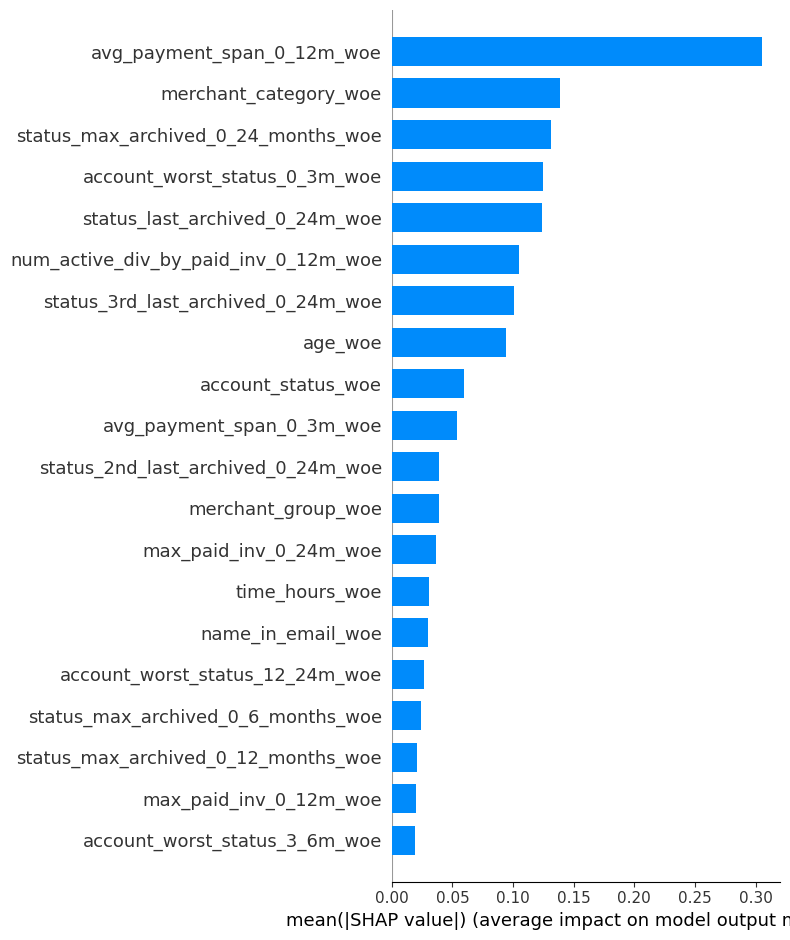

In [13]:
#d = grid_search.best_estimator_.feature_importances_
model = mod.grid_search.best_estimator_
explainer = shap.TreeExplainer(model)
shap_values = explainer(mod.train_X)
shap.summary_plot(shap_values, features=mod.train_X, feature_names= mod.train_X.columns, plot_type="bar")


In [14]:
#sample_ind = 20
#shap.plots.waterfall(shap_values[sample_ind], max_display=14)